In [143]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from scipy import stats

pd.set_option('display.max_columns', None)

# Red Wine Casus


We gaan aan de slag met een dataset over Portugese rode wijnen. Aan de hand van de gegeven dataset gaan wij een aantal onderzoeksvragen opstellen en beantwoorden.

**Onderzoeksvragen**
1. In hoeverre is de score van een Portugese Red te voorspellen op basis van de chemische kenmerken?(verplichte onderzoeksvraag)
2. Als we wijnen categoriseren op basis van de chemische samenstelling, zijn er bepaalde categorieën die mannelijke proevers anders beoordelen dan vrouwelijke proevers?
3. Kun je op basis van bepaalde keywords in de beschrijving een voorspelling doen over hoe hoog de score van deze wijn is?

In de tabel die hieronder weergegeven wordt zien we de eerste 5 records die deze dataset bevat. Onder de tabel hebben we per kolom een beschrijving gegeven van wat deze kolom precies inhoudt.

In [144]:
wine = pd.read_csv('redwine.csv', delimiter=';')
wine.head()

,id,country,description,designation,points,price,province,taster_name,title,variety,winery,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Kerin O’Keefe,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,10.0,0.29,0.4,2.9,0.098,10.0,26.0,10.006,3.48,0.91,9.7
1,2,Portugal,"From an estate in the south of the Alentejo, t...",Grande Reserva Tinto,91,26.0,Alentejano,Roger Voss,Casa Santa Vitória 2013 Grande Reserva Tinto R...,Portuguese Red,Casa Santa Vitória,8.3,0.26,0.37,1.4,0.076,8.0,23.0,0.9974,3.26,0.70,9.6
2,3,Portugal,A year in wood and 30 months in bottle before ...,Montes Claros Garrafeira,90,28.0,Alentejo,Paul Gregutt,Adega Cooperativa de Borba 2012 Montes Claros ...,Portuguese Red,Adega Cooperativa de Borba,7.0,0.69,0.07,2.5,0.091,15.0,21.0,0.99572,3.38,0.60,11.3
3,4,Portugal,Wood aging gives this ripe blend of Baga and T...,NaN,90,20.0,Beira Atlantico,Alexander Peartree,Quinta de Foz de Arouce 2013 Red (Beira Atlant...,Portuguese Red,Quinta de Foz de Arouce,7.0,0.69,0.07,2.5,0.091,15.0,21.0,0.99572,3.38,0.60,11.3
4,5,Portugal,"A powerful wine, richly structured and full of...",Gerações Colheita Seleccionada,92,34.0,Alentejano,Paul Gregutt,Herdade Grande 2010 Gerações Colheita Seleccio...,Portuguese Red,Herdade Grande,8.0,0.48,0.34,2.2,0.073,16.0,25.0,0.9936,3.28,0.66,12.4


__Beschrijving van de kolommen__
<li>Country: Het land van herkomst van de wijn. In deze dataset komt elke wijn uit Portugal, het opslaan van deze kolom is dus redelijk onnodig aangezien het bij elk record hetzelfde is.</li>
<li>Description: Een tekstuele beschrijving over de wijn.</li>
<li>Designation: Vanuit waar de wijn verkocht wordt.</li>
<li>Points: De score van de wijn op een schaal van 1-100.</li>
<li>Price: De prijs van de wijn.</li>
<li>Province: De provincie waar de wijn is gemaakt.</li>
<li>Taster_name: De naam van de persoon die de wijn geproeft heeft.</li>
<li>Title: De naam van de wijn</li>
<li>Variety: Wijnsoort. Ook hier valt het op dat alle wijnen hierbij dezelfde waarde hebben</li>
<li>Winery: De wijnmakerij waar de wijn vandaan komt.</li>

_Chemische samenstelling_
<li>Fixed acidity: vaste zuurtegraad</li>
<li>Volatile acidity: vluchtige zuurtegtraad</li>
<li>Citric acid: citroenzuur</li>
<li>Residual sugar: Natuurlijke druifsuikers die achterblijven in de wijn nadat de alcoholische fermentatie plaats heeft gevonden.</li>
<li>Chlorides: zout</li>
<li>Free sulfur dioxide: ongebonden sulfur dioxide</li>
<li>Total sulfur dioxide: totaal aantal sulfur dioxide in de wijn</li>
<li>Density: dichtheid</li>
<li>pH: pH-waarde</li>
<li>Sulphates: sulfaat</li>
<li>alcohol: alcohol percentage</li>

# Dataverkenning: Wat viel ons op?

We begonnen met het bekijken van de dataset en het documenteren van opvallende waardes. Deze data verkennings fase is belangrijk om later te kunnen beslissen welke gegevens wel of niet bruikbaar zijn om onze onderzoeksvragen te kunnen beantwoorden. 

Zo zie je bijvoorbeeld dat het gemiddelde van het aantal punten van de wijnen 88.8 is. Dit zou dus op een schaal van 1-10 uitkomen op een 8,8. 

In [145]:
np.mean(wine['points'])

88.81135902636917

Ook zie je dat het laagst gegeven cijfer een 8,1 is. Redelijk enthousiast. 

In [146]:
np.min(wine['points'])

81

Er zijn ook een aantal records waarbij lege waardes voorkomen. We moeten hierbij kijken wat we gaan doen met de lege data en of het invloed heeft op de antwoorden van onze onderzoeksvragen. 

In [147]:
wine.isnull().sum().sum()

422

De tabel hieronder toont aan dat alle tasters meer dan één wijnsoort geproeft hebben. Je ziet zelfs dat sommigen er honderden hebben beoordeeld. 

In [148]:
nameCount = wine.groupby(['taster_name']).size().reset_index(name='count')
nameCount

,taster_name,count
0,Alexander Peartree,14
1,Anna Lee C. Iijima,84
2,Anne Krebiehl MW,55
3,Carrie Dykes,3
4,Fiona Adams,3
5,Jeff Jenssen,9
6,Jim Gordon,107
7,Joe Czerwinski,143
8,Kerin O’Keefe,258
9,Lauren Buzzeo,38


# Externe dataset

We willen een externe dataset gebruiken voor het beantwoorden van een van onze onderzoeksvragen. De dataset bestaat uit engelse namen en hun geslacht. Aan de hand van de informatie uit deze dataset willen we voorspellen of de tasters in onze eigen dataset van het mannelijk of vrouwelijke geslacht zijn. 


Hieronder zien we de eerste 10 records van de externe dataset. 

In [149]:
name = pd.read_csv('names.csv', usecols=['Name','Gender'])
name.head(10)

,Name,Gender
0,Mary,F
1,Anna,F
2,Emma,F
3,Elizabeth,F
4,Minnie,F
5,Margaret,F
6,Ida,F
7,Alice,F
8,Bertha,F
9,Sarah,F


In [150]:
wine['taster_name'] = wine['taster_name'].apply(lambda name: name.split(" ")[0])

## De chemische samenstelling.

In [151]:
chemColNames = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
chem = wine[chemColNames]
chem.head()
# citric acid, density, alcohol

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,10.0,0.29,0.4,2.9,0.098,10.0,26.0,10.006,3.48,0.91,9.7
1,8.3,0.26,0.37,1.4,0.076,8.0,23.0,0.9974,3.26,0.70,9.6
2,7.0,0.69,0.07,2.5,0.091,15.0,21.0,0.99572,3.38,0.60,11.3
3,7.0,0.69,0.07,2.5,0.091,15.0,21.0,0.99572,3.38,0.60,11.3
4,8.0,0.48,0.34,2.2,0.073,16.0,25.0,0.9936,3.28,0.66,12.4


In [152]:
chem.describe(include='all')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,2465.000000,2465.000000,2465,2465.000000,2465.000000,2465.000000,2465.000000,2465,2465.000000,2465.000000,2465
unique,NaN,NaN,80,NaN,NaN,NaN,NaN,428,NaN,NaN,61
top,NaN,NaN,-,NaN,NaN,NaN,NaN,0.9976,NaN,NaN,9.5
freq,NaN,NaN,203,NaN,NaN,NaN,NaN,59,NaN,NaN,234
mean,8.352819,0.528162,NaN,2.562353,0.087485,15.804665,47.218661,NaN,3.311201,0.660353,NaN
std,1.734847,0.178869,NaN,1.407030,0.047043,10.379218,33.187830,NaN,0.153927,0.172531,NaN
min,4.600000,0.120000,NaN,0.900000,0.012000,1.000000,6.000000,NaN,2.740000,0.330000,NaN
25%,7.100000,0.400000,NaN,1.900000,0.070000,7.000000,22.000000,NaN,3.210000,0.550000,NaN
50%,7.900000,0.520000,NaN,2.200000,0.079000,14.000000,38.000000,NaN,3.310000,0.620000,NaN
75%,9.300000,0.635000,NaN,2.600000,0.091000,21.000000,64.000000,NaN,3.400000,0.730000,NaN


Hier zie je bijvoorbeeld het vershil in spreiding, wat opvalt is dat er in suiker maar vooral in sulfur een groot aantal hoge uitschieters zijn.

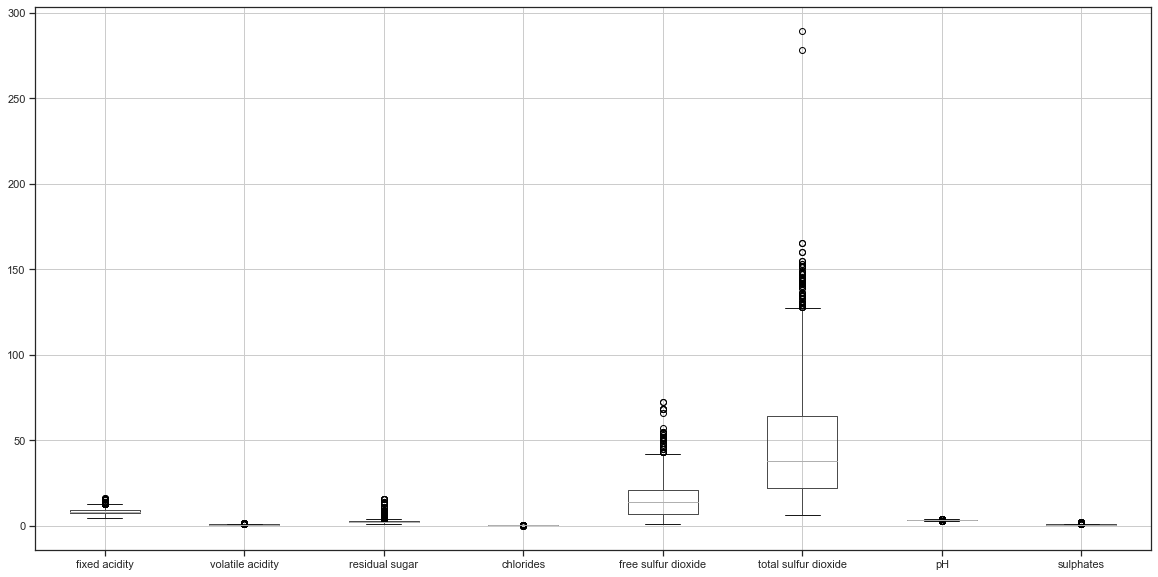

In [153]:
chem.boxplot(figsize=(20,10))

# Pair plot

Voordat we een pairplot kunnen maken moeten we de types van een aantal kolommen aanpassen. We willen bijvoorbeeld alcohol plotten en daarvoor moeten we eerst zorgen dat alcohol van het type object naar een nummeriek type geconverteerd wordt. We kunnen terwijl we dit doen ook meteen de waardes van density en citric acid omzetten naar nummerieke datatypes, mogelijk hebben we deze later nog nodig. 

In [154]:
colErrorPairs = {
    'density'    : [' . '],
    'citric acid': [' - ',' -   '],
    'alcohol'    : ['100.333.333.333.333','11.066.666.666.666.600','956.666.666.666.667','923.333.333.333.333']}

for colName in colErrorPairs:
    for faultyString in colErrorPairs[colName]:
        wine[colName] = wine[colName].replace(faultyString,np.nan)

In [155]:
# wine['alcohol'] = pd.to_numeric(wine['alcohol'], errors='coerce', downcast='float')
wine['alcohol'] = wine['alcohol'].astype(float)

In [156]:
# wine['density'] = pd.to_numeric(wine['density'], errors='coerce', downcast='float')
wine['density'] = wine['density'].astype(float)

In [157]:
# wine['citric acid'] = pd.to_numeric(wine['citric acid'], errors='coerce', downcast='float')
wine['citric acid'] = wine['citric acid'].astype(float)

In [158]:
wine.dtypes

id                        int64
country                  object
description              object
designation              object
points                    int64
price                   float64
province                 object
taster_name              object
title                    object
variety                  object
winery                   object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
dtype: object

#### Nu dat we de gewenste types hebben omgezet kunnen we ze plotten in een pairplot

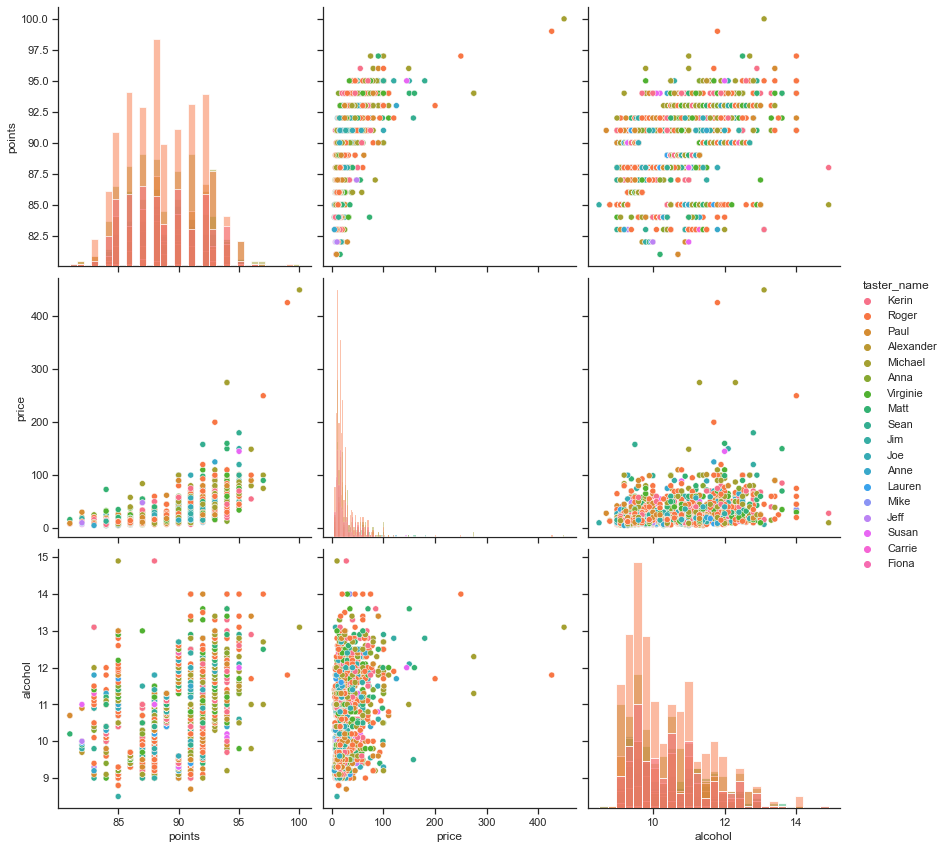

In [159]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(wine, diag_kind = "hist",
                 height = 4,
                 hue = "taster_name",

                 x_vars=["points", "price", "alcohol"], 
                 y_vars= ["points", "price", "alcohol"])

plt.show()

Hierboven zien we een pairplot waarbij we de variabelen prijs, points en alcohol met elkaar vergelijken. Elke proever heeft een apart kleurtje gekregen. 

# Standaardiseren


Stanaardiseren helpt om eerlijker te meten. Je verwijdert de eenheden en zorgt dat alle variabelen ongeveer hetzeflde bereik hebben. 

Alle variabelen die te maken hebben met de chemische samenstelling zouden ongeveer hetzelfde bereik moeten hebben. Als we ervoor zorgen dat deze waardes bijvoorbeeld allemaal tussen de 0 en 1 liggen, kunnen we ze makkelijk met elkaar vergelijken zonder dat er één veel zwaarder weegt dan de ander.


In [161]:
wineZscore = wine
for col in chemColNames:
        wineZscore[col] = (wine[col] - wine[col].mean())/wine[col].std(ddof=0)
wineZscore.head()

,id,country,description,designation,points,price,province,taster_name,title,variety,winery,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Kerin,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,0.949660,-1.331760,0.542728,0.240020,0.223558,-0.559372,-0.639480,0.827622,1.096839,1.447261,-0.678516
1,2,Portugal,"From an estate in the south of the Alentejo, t...",Grande Reserva Tinto,91,26.0,Alentejano,Roger,Casa Santa Vitória 2013 Grande Reserva Tinto R...,Portuguese Red,Casa Santa Vitória,-0.030452,-1.499514,0.380840,-0.826272,-0.244190,-0.752104,-0.729893,-0.126222,-0.332697,0.229843,-0.773610
2,3,Portugal,A year in wood and 30 months in bottle before ...,Montes Claros Garrafeira,90,28.0,Alentejo,Paul,Adega Cooperativa de Borba 2012 Montes Claros ...,Portuguese Red,Adega Cooperativa de Borba,-0.779950,0.904967,-1.238041,-0.044324,0.074729,-0.077542,-0.790169,-0.126400,0.447050,-0.349880,0.842984
3,4,Portugal,Wood aging gives this ripe blend of Baga and T...,NaN,90,20.0,Beira Atlantico,Alexander,Quinta de Foz de Arouce 2013 Red (Beira Atlant...,Portuguese Red,Quinta de Foz de Arouce,-0.779950,0.904967,-1.238041,-0.044324,0.074729,-0.077542,-0.790169,-0.126400,0.447050,-0.349880,0.842984
4,5,Portugal,"A powerful wine, richly structured and full of...",Gerações Colheita Seleccionada,92,34.0,Alentejano,Paul,Herdade Grande 2010 Gerações Colheita Seleccio...,Portuguese Red,Herdade Grande,-0.203413,-0.269315,0.218952,-0.257583,-0.307974,0.018824,-0.669618,-0.126624,-0.202740,-0.002046,1.889015
